## 第三章：PyTorch的主要组成模块
### 3.1 思考：完成深度学习的必要部分

回顾我们在完成一项机器学习任务时的步骤，首先需要对数据进行预处理，其中重要的步骤包括数据格式的统一和必要的数据变换，同时划分训练集和测试集。接下来选择模型，并设定损失函数和优化函数，以及对应的超参数（当然可以使用sklearn这样的机器学习库中模型自带的损失函数和优化器）。最后用模型去拟合训练集数据，并在验证集/测试集上计算模型表现。

深度学习和机器学习在流程上类似，但在代码实现上有较大的差异。首先，由于深度学习所需的样本量很大，一次加载全部数据运行可能会超出内存容量而无法实现；同时还有批（batch）训练等提高模型表现的策略，需要每次训练读取固定数量的样本送入模型中训练，因此深度学习在数据加载上需要有专门的设计。

在模型实现上，深度学习和机器学习也有很大差异。由于深度神经网络层数往往较多，同时会有一些用于实现特定功能的层（如卷积层、池化层、批正则化层、LSTM层等），因此深度神经网络往往需要“逐层”搭建，或者预先定义好可以实现特定功能的模块，再把这些模块组装起来。这种“定制化”的模型构建方式能够充分保证模型的灵活性，也对代码实现提出了新的要求。

接下来是损失函数和优化器的设定。这部分和经典机器学习的实现是类似的。但由于模型设定的灵活性，因此损失函数和优化器要能够保证反向传播能够在用户自行定义的模型结构上实现。

上述步骤完成后就可以开始训练了。我们前面介绍了GPU的概念和GPU用于并行计算加速的功能，不过程序默认是在CPU上运行的，因此在代码实现中，需要把模型和数据“放到”GPU上去做运算，同时还需要保证损失函数和优化器能够在GPU上工作。如果使用多张GPU进行训练，还需要考虑模型和数据分配、整合的问题。此外，后续计算一些指标还需要把数据“放回”CPU。这里涉及到了一系列有关于GPU的配置和操作。

深度学习中训练和验证过程最大的特点在于读入数据是按批的，每次读入一个批次的数据，放入GPU中训练，然后将损失函数反向传播回网络最前面的层，同时使用优化器调整网络参数。这里会涉及到各个模块配合的问题。训练/验证后还需要根据设定好的指标计算模型表现。

经过以上步骤，一个深度学习任务就完成了。我们在详细讲解每个部分之前，先梳理了完成各个部分所需的功能，下面我们就去进一步了解一下PyTorch是如何实现各个部分的，以及PyTorch作为一个深度学习框架拥有的模块化特点。

### 3.2 基本配置
首先导入必须的包。对于一个PyTorch项目，我们需要导入一些Python常用的包来帮助我们快速实现功能。常见的包有os、numpy等，此外还需要调用PyTorch自身一些模块便于灵活使用，比如torch、torch.nn、torch.utils.data.Dataset、torch.utils.data.DataLoader、torch.optimizer等等。注意这里**只是建议导入的包导入的方式**，可以采用不同的方案，比如涉及到表格信息的读入很可能用到pandas，对于不同的项目可能还需要导入一些更上层的包如cv2等。如果涉及可视化还会用到matplotlib、seaborn等。涉及到下游分析和指标计算也常用到sklearn。

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optimizer

根据前面我们对深度学习任务的梳理，有如下几个超参数可以统一设置，方便后续调试时修改：

- batch size

- 初始学习率（初始）

- 训练次数（max_epochs）

- GPU配置

In [3]:
batch_size = 16
lr = 1e-4
max_epochs = 100

# GPU的设置有两种常见的方式：
# 方案一：使用os.environ，这种情况如果使用GPU不需要设置
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# 当然还会有一些其他模块或用户自定义模块会用到的参数，有需要也可以在一开始进行设置。

### 3.3 数据读入
PyTorch数据读入是通过Dataset+DataLoader的方式完成的，Dataset定义好数据的格式和数据变换形式，DataLoader用iterative的方式不断读入批次数据。

我们可以定义自己的Dataset类来实现灵活的数据读取，定义的类需要继承PyTorch自身的Dataset类。主要包含三个函数：

- `__init__`: 用于向类中传入外部参数，同时定义样本集
- `__getitem__`: 用于逐个读取样本集合中的元素，可以进行一定的变换，并将返回训练/验证所需的数据
- `__len__`: 用于返回数据集的样本数

下面以cifar10数据集为例给出构建Dataset类的方式：


In [5]:
import torch
import torchvision

# train_data = torchvision.datasets.ImageFolder(train_path, transform=data_transform)
# val_data = torchvision.datasets.ImageFolder(val_path, transform=data_transform)

这里使用了PyTorch自带的ImageFolder类的用于读取按一定结构存储的图片数据（path对应图片存放的目录，目录下包含若干子目录，每个子目录对应属于同一个类的图片）。

其中“data_transform”可以对图像进行一定的变换，如翻转、裁剪等操作，可自己定义。这里我们会在下一章通过实战加以介绍。

这里另外给出一个例子，其中图片存放在一个文件夹，另外有一个csv文件给出了图片名称对应的标签。这种情况下需要自己来定义Dataset类：

In [ ]:

class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)

构建好Dataset后，就可以使用DataLoader来按批次读入数据了，实现代码如下：



In [ ]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4, shuffle=False)

其中:

- batch_size：样本是按“批”读入的，batch_size就是每次读入的样本数

- num_workers：有多少个进程用于读取数据

- shuffle：是否将读入的数据打乱

- drop_last：对于样本最后一部分没有达到批次数的样本，使其不再参与训练

这里可以看一下我们的加载的数据。PyTorch中的DataLoader的读取可以使用next和iter来完成

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(iter(val_loader))
print(images.shape)
plt.imshow(images[0].transpose(1,2,0))
plt.show()

### 3.4 模型构建
#### 3.4.1 神经网络的构造
PyTorch中神经网络构造一般是基于 Module 类的模型来完成的，它让模型构造更加灵活。

Module 类是 nn 模块里提供的一个模型构造类，是所有神经⽹网络模块的基类，我们可以继承它来定义我们想要的模型。下面继承 Module 类构造多层感知机。这里定义的 MLP 类重载了 Module 类的 init 函数和 forward 函数。它们分别用于创建模型参数和定义前向计算。前向计算也即正向传播。

In [7]:
import torch
from torch import nn

class MLP(nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = nn.Linear(784, 256)
    self.act = nn.ReLU()
    self.output = nn.Linear(256,10)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)   

以上的 MLP 类中⽆须定义反向传播函数。系统将通过⾃动求梯度⽽自动⽣成反向传播所需的 backward 函数。

我们可以实例化 MLP 类得到模型变量 net 。下⾯的代码初始化 net 并传入输⼊数据 X 做一次前向计算。其中， net(X) 会调用 MLP 继承⾃自 Module 类的 call 函数，这个函数将调⽤用 MLP 类定义的forward 函数来完成前向计算。

In [8]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)

MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[-0.1020,  0.0023,  0.0523,  0.0668, -0.0928,  0.0823, -0.2623, -0.1813,
         -0.0592,  0.0635],
        [ 0.0008, -0.0313, -0.0199,  0.0857, -0.1672,  0.0545, -0.2838, -0.1612,
         -0.1343, -0.0011]], grad_fn=<AddmmBackward0>)

注意，这里并没有将 Module 类命名为 Layer (层)或者 Model (模型)之类的名字，这是因为该类是一个可供⾃由组建的部件。它的子类既可以是⼀个层(如PyTorch提供的 Linear 类)，⼜可以是一个模型(如这里定义的 MLP 类)，或者是模型的⼀个部分。

#### 3.4.2 神经网络中常见的层
深度学习的一个魅力在于神经网络中各式各样的层，例如全连接层、卷积层、池化层与循环层等等。虽然PyTorch提供了⼤量常用的层，但有时候我们依然希望⾃定义层。这里我们会介绍如何使用 Module 来自定义层，从而可以被反复调用。

- **不含模型参数的层**

我们先介绍如何定义一个不含模型参数的自定义层。下⾯构造的 MyLayer 类通过继承 Module 类自定义了一个**将输入减掉均值后输出**的层，并将层的计算定义在了 forward 函数里。这个层里不含模型参数。

In [11]:
import torch
from torch import nn

class MyLayer(nn.Module):
    def __init__(self):
        super(MyLayer, self).__init__()
    def forward(self, x):
        return x - x.mean()  

In [12]:
# 测试，实例化该层，然后做前向计算
layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))


tensor([-2., -1.,  0.,  1.,  2.])

- **含模型参数的层**

我们还可以自定义含模型参数的自定义层。其中的模型参数可以通过训练学出。

Parameter 类其实是 Tensor 的子类，如果一 个 Tensor 是 Parameter ，那么它会⾃动被添加到模型的参数列表里。所以在⾃定义含模型参数的层时，我们应该将参数定义成 Parameter ，除了直接定义成 Parameter 类外，还可以使⽤ ParameterList 和 ParameterDict 分别定义参数的列表和字典。

In [13]:
class MyListDense(nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])
        return x
net = MyListDense()
print(net)

MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)


In [15]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)

# 下面给出常见的神经网络的一些层，比如卷积层、池化层，以及较为基础的AlexNet，LeNet等。

MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


- **二维卷积层**

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差。


In [ ]:
import torch
from torch import nn

# 卷积运算（二维互相关）
def corr2d(X, K): 
    h, w = K.shape
    X, K = X.float(), K.float()
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

# 二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

卷积窗口形状为 \(p \times q\) 的卷积层称为 \(p \times q\) 卷积层。同样， \(p \times q\) 卷积或 \(p \times q\) 卷积核说明卷积核的高和宽分别为 \(p\) 和 \(q\)。

填充(padding)是指在输⼊高和宽的两侧填充元素(通常是0元素)。

下面的例子里我们创建一个⾼和宽为3的二维卷积层，然后设输⼊高和宽两侧的填充数分别为1。给定一 个高和宽为8的输入，我们发现输出的高和宽也是8。

In [16]:
import torch
from torch import nn

# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
import torch
from torch import nn

# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    # (1, 1)代表批量大小和通道数
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.view(Y.shape[2:]) # 排除不关心的前两维:批量和通道


# 注意这里是两侧分别填充1⾏或列，所以在两侧一共填充2⾏或列
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,padding=1)

X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [20]:
# 当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽。

# 使用高为5、宽为3的卷积核。在⾼和宽两侧的填充数分别为2和1
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
print(comp_conv2d(conv2d, X).shape)

# 在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下 的顺序，
# 依次在输⼊数组上滑动。我们将每次滑动的行数和列数称为步幅(stride)。
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])


torch.Size([2, 2])

- **池化层**

池化层每次对输入数据的一个固定形状窗口(⼜称池化窗口)中的元素计算输出。不同于卷积层里计算输⼊和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也 分别叫做最大池化或平均池化。在二维最⼤池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输⼊数组上滑动。当池化窗口滑动到某⼀位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

下面把池化层的前向计算实现在`pool2d`函数里。

In [21]:
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [22]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float)
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [23]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

我们可以使用`torch.nn`包来构建神经网络。我们已经介绍了`autograd`包，`nn`包则依赖于`autograd`包来定义模型并对它们求导。一个`nn.Module`包含各个层和一个`forward(input)`方法，该方法返回`output`。


#### 3.4.3 模型示例

#####  **LeNet**

![3.4.1](https://datawhalechina.github.io/thorough-pytorch/_images/3.4.1.png)

这是一个简单的前馈神经网络 (feed-forward network）（LeNet）。它接受一个输入，然后将它送入下一层，一层接一层的传递，最后给出输出。

一个神经网络的典型训练过程如下：

1. 定义包含一些可学习参数(或者叫权重）的神经网络
2. 在输入数据集上迭代
3. 通过网络处理输入
4. 计算 loss (输出和正确答案的距离）
5. 将梯度反向传播给网络的参数
6. 更新网络的权重，一般使用一个简单的规则：`weight = weight - learning_rate * gradient`

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


我们只需要定义 `forward` 函数，`backward`函数会在使用`autograd`时自动定义，`backward`函数用来计算导数。我们可以在 `forward` 函数中使用任何针对张量的操作和计算。

一个模型的可学习参数可以通过`net.parameters()`返回

In [25]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

10
torch.Size([6, 1, 5, 5])


让我们尝试一个随机的 32x32 的输入。注意:这个网络 (LeNet）的期待输入是 32x32 的张量。如果使用 MNIST 数据集来训练这个网络，要把图片大小重新调整到 32x32。



In [26]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.2296,  0.0041,  0.0776, -0.1270,  0.0846, -0.0464, -0.1176, -0.0244,
          0.1141,  0.1952]], grad_fn=<AddmmBackward0>)


In [27]:
# 清零所有参数的梯度缓存，然后进行随机梯度的反向传播：
net.zero_grad()
out.backward(torch.randn(1, 10))


注意：`torch.nn`只支持小批量处理 (mini-batches）。整个 `torch.nn` 包只支持小批量样本的输入，不支持单个样本的输入。比如，`nn.Conv2d` 接受一个4维的张量，即`nSamples x nChannels x Height x Width `如果是一个单独的样本，只需要使用`input.unsqueeze(0)` 来添加一个“假的”批大小维度。

- `torch.Tensor` - 一个多维数组，支持诸如`backward()`等的自动求导操作，同时也保存了张量的梯度。
- `nn.Module `- 神经网络模块。是一种方便封装参数的方式，具有将参数移动到GPU、导出、加载等功能。
- `nn.Parameter `- 张量的一种，当它作为一个属性分配给一个`Module`时，它会被自动注册为一个参数。
- `autograd.Function` - 实现了自动求导前向和反向传播的定义，每个`Tensor`至少创建一个`Function`节点，该节点连接到创建`Tensor`的函数并对其历史进行编码。

下面再介绍一个比较基础的案例AlexNet

##### **AlexNet**

![3.4.2](https://datawhalechina.github.io/thorough-pytorch/_images/3.4.2.png)

In [28]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [29]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

### 3.5 模型初始化

在深度学习模型的训练中，权重的初始值极为重要。一个好的权重值，会使模型收敛速度提高，使模型准确率更精确。为了利于训练和减少收敛时间，我们需要对模型进行合理的初始化。PyTorch也在`torch.nn.init`中为我们提供了常用的初始化方法。 通过本章学习，你将学习到以下内容：

- 常见的初始化函数
- 初始化函数的使用

#### torch.nn.init内容

通过访问torch.nn.init的官方文档[链接](https://pytorch.org/docs/stable/nn.init.html) ，我们发现`torch.nn.init`提供了以下初始化方法： 1 . `torch.nn.init.uniform_`(tensor, a=0.0, b=1.0) 2 . `torch.nn.init.normal_`(tensor, mean=0.0, std=1.0) 3 . `torch.nn.init.constant_`(tensor, val) 4 . `torch.nn.init.ones_`(tensor) 5 . `torch.nn.init.zeros_`(tensor) 6 . `torch.nn.init.eye_`(tensor) 7 . `torch.nn.init.dirac_`(tensor, groups=1) 8 . `torch.nn.init.xavier_uniform_`(tensor, gain=1.0) 9 . `torch.nn.init.xavier_normal_`(tensor, gain=1.0) 10 . `torch.nn.init.kaiming_uniform_`(tensor, a=0, mode='fan__in', nonlinearity='leaky_relu') 11 . `torch.nn.init.kaiming_normal_`(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu') 12 . `torch.nn.init.orthogonal_`(tensor, gain=1) 13 . `torch.nn.init.sparse_`(tensor, sparsity, std=0.01) 14 . `torch.nn.init.calculate_gain`(nonlinearity, param=None) 关于计算增益如下表：

| nonlinearity    | gain                 |
| --------------- | -------------------- |
| Linear/Identity | 1                    |
| Conv{1,2,3}D    | 1                    |
| Sigmod          | 1                    |
| Tanh            | 5/3                  |
| ReLU            | sqrt(2)              |
| Leaky Relu      | sqrt(2/1+neg_slop^2) |

我们可以发现这些函数除了`calculate_gain`，所有函数的后缀都带有下划线，意味着这些函数将会直接原地更改输入张量的值。

#### torch.nn.init使用

我们通常会根据实际模型来使用`torch.nn.init`进行初始化，通常使用`isinstance`来进行判断模块（回顾3.4模型构建）属于什么类型。

```
import torch
import torch.nn as nn

conv = nn.Conv2d(1,3,3)
linear = nn.Linear(10,1)

isinstance(conv,nn.Conv2d)
isinstance(linear,nn.Conv2d)
True
False
```

对于不同的类型层，我们就可以设置不同的权值初始化的方法。

```
# 查看随机初始化的conv参数
conv.weight.data
# 查看linear的参数
linear.weight.data
tensor([[[[ 0.1174,  0.1071,  0.2977],
          [-0.2634, -0.0583, -0.2465],
          [ 0.1726, -0.0452, -0.2354]]],
        [[[ 0.1382,  0.1853, -0.1515],
          [ 0.0561,  0.2798, -0.2488],
          [-0.1288,  0.0031,  0.2826]]],
        [[[ 0.2655,  0.2566, -0.1276],
          [ 0.1905, -0.1308,  0.2933],
          [ 0.0557, -0.1880,  0.0669]]]])

tensor([[-0.0089,  0.1186,  0.1213, -0.2569,  0.1381,  0.3125,  0.1118, -0.0063, -0.2330,  0.1956]])
# 对conv进行kaiming初始化
torch.nn.init.kaiming_normal_(conv.weight.data)
conv.weight.data
# 对linear进行常数初始化
torch.nn.init.constant_(linear.weight.data,0.3)
linear.weight.data
tensor([[[[ 0.3249, -0.0500,  0.6703],
          [-0.3561,  0.0946,  0.4380],
          [-0.9426,  0.9116,  0.4374]]],
        [[[ 0.6727,  0.9885,  0.1635],
          [ 0.7218, -1.2841, -0.2970],
          [-0.9128, -0.1134, -0.3846]]],
        [[[ 0.2018,  0.4668, -0.0937],
          [-0.2701, -0.3073,  0.6686],
          [-0.3269, -0.0094,  0.3246]]]])
tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,0.3000]])
```

#### 初始化函数的封装

人们常常将各种初始化方法定义为一个`initialize_weights()`的函数并在模型初始后进行使用。

```
def initialize_weights(self):
	for m in self.modules():
		# 判断是否属于Conv2d
		if isinstance(m, nn.Conv2d):
			torch.nn.init.xavier_normal_(m.weight.data)
			# 判断是否有偏置
			if m.bias is not None:
				torch.nn.init.constant_(m.bias.data,0.3)
		elif isinstance(m, nn.Linear):
			torch.nn.init.normal_(m.weight.data, 0.1)
			if m.bias is not None:
				torch.nn.init.zeros_(m.bias.data)
		elif isinstance(m, nn.BatchNorm2d):
			m.weight.data.fill_(1) 		 
			m.bias.data.zeros_()	
```

这段代码流程是遍历当前模型的每一层，然后判断各层属于什么类型，然后根据不同类型层，设定不同的权值初始化方法。我们可以通过下面的例程进行一个简短的演示：

```
# 模型的定义
class MLP(nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = nn.Conv2d(1,1,3)
    self.act = nn.ReLU()
    self.output = nn.Linear(10,1)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)

mlp = MLP()
print(list(mlp.parameters()))
print("-------初始化-------")

initialize_weights(mlp)
print(list(mlp.parameters()))
[Parameter containing:
tensor([[[[ 0.2103, -0.1679,  0.1757],
          [-0.0647, -0.0136, -0.0410],
          [ 0.1371, -0.1738, -0.0850]]]], requires_grad=True), Parameter containing:
tensor([0.2507], requires_grad=True), Parameter containing:
tensor([[ 0.2790, -0.1247,  0.2762,  0.1149, -0.2121, -0.3022, -0.1859,  0.2983,
         -0.0757, -0.2868]], requires_grad=True), Parameter containing:
tensor([-0.0905], requires_grad=True)]
"-------初始化-------"
[Parameter containing:
 tensor([[[[-0.3196, -0.0204, -0.5784],
           [ 0.2660,  0.2242, -0.4198],
           [-0.0952,  0.6033, -0.8108]]]], requires_grad=True),
 Parameter containing:
 tensor([0.3000], requires_grad=True),
 Parameter containing:
 tensor([[ 0.7542,  0.5796,  2.2963, -0.1814, -0.9627,  1.9044,  0.4763,  1.2077,
           0.8583,  1.9494]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]
```


# 第四章：PyTorch基础实战

### 基础实战——FashionMNIST时装分类

经过前面三章内容的学习，我们完成了以下的内容：

- 对PyTorch有了初步的认识
- 学会了如何安装PyTorch以及对应的编程环境
- 学习了PyTorch最核心的理论基础（张量&自动求导）
- 梳理了利用PyTorch完成深度学习的主要步骤和对应实现方式

现在，我们通过一个基础实战案例，将第一部分所涉及的PyTorch入门知识串起来，便于大家加深理解。同时为后续的进阶学习打好基础。

我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为28*28pixel，分属10个类别。

下面让我们一起将第三章各部分内容逐步实现，来跑完整个深度学习流程。

**首先导入必要的包**

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset,DataLoader

In [25]:
# 配置训练环境和超参数
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

**数据读入和加载**
这里同时展示两种方式:

- 下载并使用PyTorch提供的内置数据集
- 从网站下载以csv格式存储的数据，读入并转成预期的格式
  第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）
  第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要

同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。

这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [20]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [16]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [21]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

In [26]:
# 在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


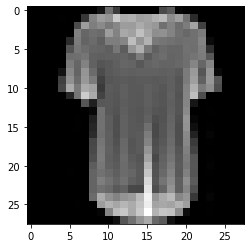

In [27]:
# 读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

#### 模型设计
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构，模型构建完成后，将模型放到GPU上用于训练。

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

#### 设定损失函数
使用torch.nn模块自带的CrossEntropy损失
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [29]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

In [33]:
# 这里方便看一下weighting等策略
?nn.CrossEntropyLoss

Init signature:
nn.CrossEntropyLoss(
    weight: Union[torch.Tensor, NoneType] = None,
    size_average=None,
    ignore_index: int = -100,
    reduce=None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> None
Docstring:     
This criterion computes the cross entropy loss between input and target.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain raw, unnormalized scores for each class.
`input` has to be a Tensor of size either :math:`(minibatch, C)` or
:math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
`K`-dimensional case. The latter is useful for higher dimension inputs, such
as computing cross entropy loss per-pixel for 2D images.

The `target` that this criterion expects should contain either:

- Class

#### 设定优化器
这里我们使用Adam优化器

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### 训练和测试（验证）
各自封装成函数，方便后续调用
关注两者的主要区别：

- 模型状态设置

- 是否需要初始化优化器

- 是否需要将loss传回到网络

- 是否需要每步更新optimizer

此外，对于测试或验证过程，可以计算分类准确率

In [35]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [36]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [37]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.626581
Epoch: 1 	Validation Loss: 0.390644, Accuracy: 0.859900
Epoch: 2 	Training Loss: 0.398027
Epoch: 2 	Validation Loss: 0.330118, Accuracy: 0.881300
Epoch: 3 	Training Loss: 0.348101
Epoch: 3 	Validation Loss: 0.298876, Accuracy: 0.892600
Epoch: 4 	Training Loss: 0.318027
Epoch: 4 	Validation Loss: 0.282844, Accuracy: 0.899000
Epoch: 5 	Training Loss: 0.300405
Epoch: 5 	Validation Loss: 0.262062, Accuracy: 0.902400
Epoch: 6 	Training Loss: 0.284113
Epoch: 6 	Validation Loss: 0.252238, Accuracy: 0.906700
Epoch: 7 	Training Loss: 0.267998
Epoch: 7 	Validation Loss: 0.242292, Accuracy: 0.908900
Epoch: 8 	Training Loss: 0.257782
Epoch: 8 	Validation Loss: 0.233853, Accuracy: 0.913800
Epoch: 9 	Training Loss: 0.248029
Epoch: 9 	Validation Loss: 0.233900, Accuracy: 0.914700
Epoch: 10 	Training Loss: 0.239142
Epoch: 10 	Validation Loss: 0.229731, Accuracy: 0.915500
Epoch: 11 	Training Loss: 0.229392
Epoch: 11 	Validation Loss: 0.237546, Accuracy: 0.908200
Epoch:

In [42]:
train_loader.dataset[0][1]

tensor(2)

#### 模型保存
训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型
这部分会在后面的课程中详细介绍

In [43]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)